# This notebook a provides a gentle introduction to convolutions, inspired by Penn State Math 497 Notes and Stanford CS231 [notes](http://cs231n.github.io/convolutional-networks) on convolutional networks.


### 1) We will construct a few convolutional kernels from scratch and plot the resulting images to gain intuition about what is going on when we call nn.Conv2d in Pytorch. 

- #### We will start with the following convolution:
 $x_{conv1}= self.conv1(x)$ with $stride=1$,  $padding=2$ and the Laplacian kernel:

 $$
Kernel_1=\begin{bmatrix} 
0 & 0 & -1 & 0 & 0 \\                 
0&-1&-2&-1& 0\\
-1&-2&16&-2&-1\\
0&-1&-2&-1& 0\\
0& 0&-1& 0& 0 
\end{bmatrix}
$$


- ####  Then, we apply a ReLU activation function:
 $x_{relu} = max(0, x_{conv1})$

- ####  Finally, apply a second convolution:
 $x_{conv2}= self.conv2(x_{relu})$  with $stride=1$,  $padding=1$ and the averaging kernel:
### $$
Kernel_2=\begin{bmatrix} 
\frac{1}{9} & \frac{1}{9} &\frac{1}{9}  \\                 
\frac{1}{9} & \frac{1}{9} &\frac{1}{9}  \\                 
\frac{1}{9} & \frac{1}{9} &\frac{1}{9}  
\end{bmatrix}
$$


Original image


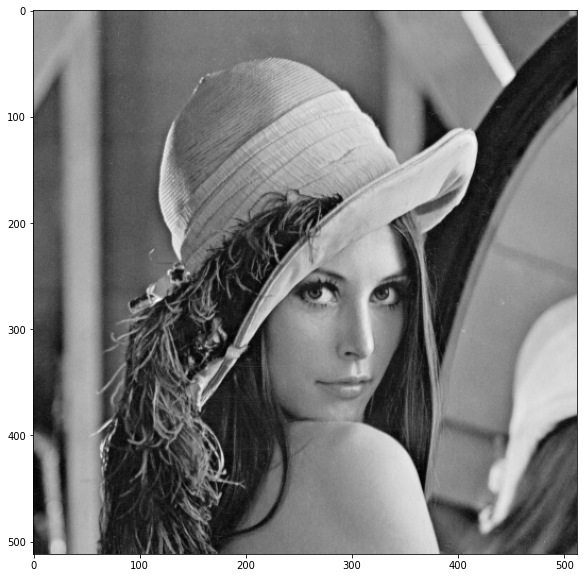


 Image after first convolution


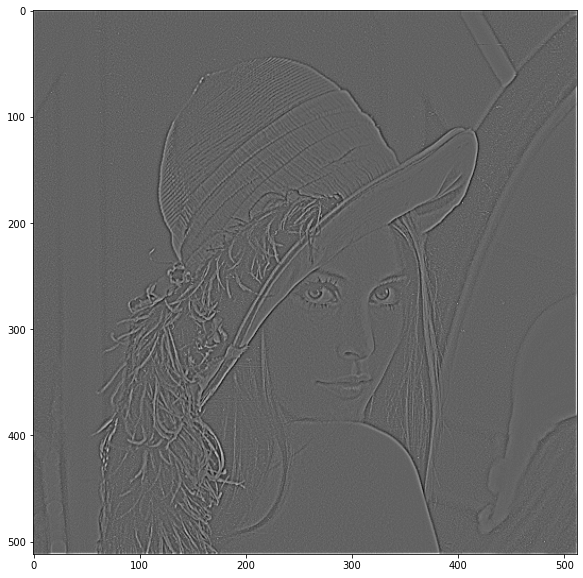


 Image after first convolution and ReLU


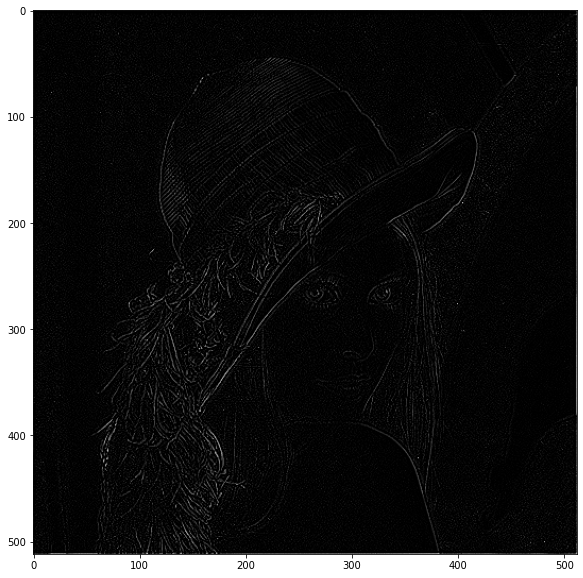


 Image after first convolution, ReLU, and second convolution


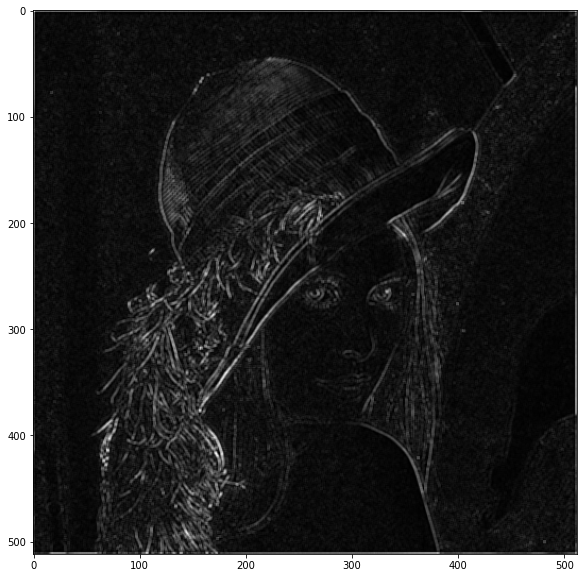

In [ ]:
from PIL import Image
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

# Read data
def read_image():    
    im = Image.open('./lena.png')
    im_array = np.array(im)
    # Convert im_array to 4D torch.tensor 
    im_array=torch.from_numpy(im_array)
    im_array=im_array.reshape(1,1,im_array.size(0),im_array.size(1))
    im_array=im_array.type(torch.FloatTensor)
    return im_array

# Define function to plot the image, input is 4D tensor
def plot_images(images):
    plt.rcParams["figure.figsize"]=10,10 # change the figure size for plotting
    images_for_plot = images[0,0,:,:] 
    plt.imshow(images_for_plot.detach().numpy(), cmap='gray') 
    plt.show()
    

# Define convolution and relu operators under model object

class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()

        # First convolutional layer
        kernel_1 = torch.tensor([[0, 0, -1, 0, 0],[0, -1, -2, -1, 0], [-1, -2, 16, -2, -1],
                                [0, -1, -2, -1, 0], [0, 0, -1, 0, 0]],dtype=torch.float32)

        # Reshape kernel to match 4D image tensor and assign kernel to conv1 layer.
        kernel_1 = kernel_1.reshape(1,1,kernel_1.size(0),kernel_1.size(1)) 
        self.conv1 = nn.Conv2d(1, 1, kernel_1.size(2), padding=2)
        self.conv1.weight = torch.nn.Parameter(kernel_1)

        # Second convolutional layer
        kernel_2 = torch.tensor([[(1/9),(1/9),(1/9)], [(1/9),(1/9),(1/9)],
                                 [(1/9),(1/9),(1/9)]], dtype=torch.float32) 
        kernel_2 = kernel_2.reshape(1,1,kernel_2.size(0), kernel_2.size(1))
        self.conv2 = nn.Conv2d(1,1, kernel_2.size(2), padding =1)
        self.conv2.weight = torch.nn.Parameter(kernel_2)
        
    def forward(self, x):
        x_conv1 = self.conv1(x)
        x_relu = F.relu(self.conv1(x_conv1))
        x_conv2 = self.conv2(x_relu)
        return x_conv1, x_relu, x_conv2
    
# Show results:
x=read_image()
my_model=model()
x_conv1,x_relu,x_conv2 = my_model(x)

print('Original image')
plot_images(x)
print('\n Image after first convolution')
plot_images(x_conv1)
print('\n Image after first convolution and ReLU')
plot_images(x_relu)
print('\n Image after first convolution, ReLU, and second convolution')
plot_images(x_conv2)

###The Laplacian filter is designed to detect rapid intensity changes in the image. This makes it a great option for sharpening the edges of an image. Applying a ReLU activation function then detects the edges of the image - the regions of the image that have high intensity are outlined, and the rest of the pixels are set to 0. Finally, the second convolution replaces each pixel in an image with the average value of it's neighbors, acting as an image smoother.

=================================================================================================================

### Now that we have some idea of what all these convolutions are doing to our images, we'll implement LeNet-5, the 'hello world' of CNNs. We'll use cross-entropy as our loss function and SGD as our optimizer, and train on MNIST digits. 

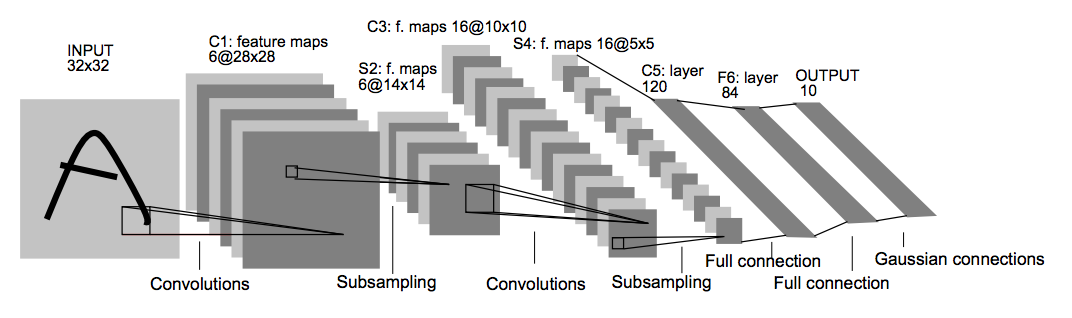

LeNet-5 Architecture. [LeCun, et al. 1998](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdfs)

In [ ]:
import torch
import torch.nn as nn 
import torch.optim as optim
import torchvision
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)


# LeNet-5 model implementation
class model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.avg_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1) 
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

# Define model, use GPU if available
my_model = model()
if use_cuda:
    my_model = my_model.cuda()


# Helper function, simple step decay lr schedule
def adjust_learning_rate(optimizer, epoch, init_lr):
    lr = init_lr * 0.5 ** (epoch // 10) #halve lr every 10 epochs
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr   

#Define hyperparameters
init_lr = 0.3
minibatch_size = 32
num_epochs = 30

# Cross entropy loss function and SGD training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=init_lr, weight_decay = 0.0001)


# Load MNIST into pytorch
MNIST_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((32, 32)),
                                                  torchvision.transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train= True, download=True, transform=MNIST_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size)
testset = torchvision.datasets.MNIST(root='./data', train= False, download=True, transform=MNIST_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset)) 


# Training LeNet-5
for epoch in range(num_epochs):
    current_lr = adjust_learning_rate(optimizer, epoch, init_lr)
    my_model.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()

        # Compute losses
        outputs = my_model(images) 
        loss = criterion(outputs, labels)
        
        # Compute gradient, backprop
        optimizer.zero_grad()
        loss.backward()  

        #Update parameters
        optimizer.step() 
        
    # Compute training accuracy
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()  
        outputs = my_model(images)
        p_max, predicted = torch.max(outputs, 1) 
        total += labels.size(0)
        correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total

    
    # Compute test accuracy
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()
        outputs = my_model(images)
        p_max, predicted = torch.max(outputs, 1) 
        total += labels.size(0)
        correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total
        
    print('Epoch: {}, Training accuracy: {}, Test accuracy: {}' .format(epoch+1,training_accuracy,test_accuracy))

Use GPU? True
Epoch: 1, Training accuracy: 0.9659333333333333, Test accuracy: 0.9656
Epoch: 2, Training accuracy: 0.9765166666666667, Test accuracy: 0.9768
Epoch: 3, Training accuracy: 0.9809166666666667, Test accuracy: 0.9803
Epoch: 4, Training accuracy: 0.9848333333333333, Test accuracy: 0.9842
Epoch: 5, Training accuracy: 0.9879666666666667, Test accuracy: 0.986
Epoch: 6, Training accuracy: 0.9903833333333333, Test accuracy: 0.987
Epoch: 7, Training accuracy: 0.9911, Test accuracy: 0.9874
Epoch: 8, Training accuracy: 0.99305, Test accuracy: 0.9885
Epoch: 9, Training accuracy: 0.9923, Test accuracy: 0.987
Epoch: 10, Training accuracy: 0.9930666666666667, Test accuracy: 0.9884
Epoch: 11, Training accuracy: 0.9935333333333334, Test accuracy: 0.9886
Epoch: 12, Training accuracy: 0.9940833333333333, Test accuracy: 0.9883
Epoch: 13, Training accuracy: 0.9948, Test accuracy: 0.989
Epoch: 14, Training accuracy: 0.9956333333333334, Test accuracy: 0.9891
Epoch: 15, Training accuracy: 0.993133

#### 98.81% test accuracy, looks pretty good! 